## CUNY MSDA Fall 2017 Semester
### DATA 620
### Project 1: Tumblr Blog Centrality and Likes
By Dmitriy Vecheruk

# Project Overview

**[Video Walkthrough](https://youtu.be/Fanc3BzCmr8)** 

**Assignment**  
Your task in this week’s assignment is to identify an interesting set of network data that is available on the web (either through web scraping or web APIs) that could be used for analyzing and comparing centrality measures across nodes. As an additional constraint, there should be at least one categorical variable available for each node (such as “Male” or “Female”; “Republican”, “Democrat,” or “Undecided”, etc.)
In addition to identifying your data source, you should create a high level plan that describes how you would load the data for analysis, and describe a hypothetical outcome that could be predicted from comparing degree centrality across categorical groups.

**Approach**  

*1) Data source:*  
I would like to use a popular image/media blogging platform Tumblr to investigate the relationships between a sample of blogs. Tumblr allows a user to "like" other users' individual posts.  
My analysis will test the assumption that blogs of users that make a lot of posts will also have a higher degree centrality, as other users will "like" their blogs more. In other words, if quantity of the content turns into quality.  

*2) Data collection approach:*  
First, I will use the `pytumblr` module developed by Tumblr as an API wrapper for the Python language. Using this module, I will collect the data on the liked blogs using snowball sampling starting from a single "seed blog".  
Secondly, I will use the API to collect the number of posts per blog in the dataset and convert it into a binary categorical variable of having produced below / above a certain number *n* of posts.  

*3) Data analysis approach:*  
I will use `networkx` to build the graph of the network and compute degree centrality for each blog. I would then apply a two-means t-test to test the average degree centrality for the blogs that have made more and less posts.


# Part 1: Generating a graph of Tumblr likes

In [1]:
import pytumblr
import networkx as net
import matplotlib
from pathlib2 import Path
import pandas as pd
%matplotlib inline

In [2]:
# Read the OAuth secret

auth_info = [line.strip() for line in open("tumblr_auth.txt")]
auth_info = [item.strip("'") for item in auth_info]

In [3]:
# Set up the client
client = pytumblr.TumblrRestClient(auth_info[0],auth_info[1],auth_info[2],auth_info[3])

# Make the request
client.info()


{u'user': {u'blogs': [{u'admin': True,
    u'ask': False,
    u'ask_anon': False,
    u'ask_page_title': u'Ask me anything',
    u'can_send_fan_mail': True,
    u'can_subscribe': False,
    u'description': u'',
    u'drafts': 0,
    u'facebook': u'N',
    u'facebook_opengraph_enabled': u'N',
    u'followed': False,
    u'followers': 1,
    u'is_adult': False,
    u'is_blocked_from_primary': False,
    u'is_nsfw': False,
    u'likes': 0,
    u'messages': 0,
    u'name': u'annoyingapinerd',
    u'posts': 0,
    u'primary': True,
    u'queue': 0,
    u'reply_conditions': u'3',
    u'share_likes': True,
    u'subscribed': False,
    u'title': u'Untitled',
    u'total_posts': 0,
    u'tweet': u'N',
    u'twitter_enabled': False,
    u'twitter_send': False,
    u'type': u'public',
    u'updated': 0,
    u'url': u'https://annoyingapinerd.tumblr.com/'}],
  u'default_post_format': u'html',
  u'following': 0,
  u'likes': 0,
  u'name': u'annoyingapinerd'}}

In [4]:
def get_liked_blogs(blog_name):
    blog_liked_blogs = []
    
    try:
        blog_liked_posts = client.blog_likes(blog_name)["liked_posts"]
    except KeyError:
        return []
    
    blog_liked_blogs = list(set([item["blog_name"] for item in blog_liked_posts]))
    
    return blog_liked_blogs

In [5]:
def collate_blog_data(blog_name):

    # Collect the attributes of this blog
    blog_info = client.blog_info(blog_name)
    blog_info = blog_info["blog"]
    
    try:
        blog_like_cnt = blog_info["likes"]
    except KeyError:
        blog_like_cnt = 0
    try:
        blog_post_cnt = blog_info["total_posts"]
    except KeyError:
        blog_post_cnt = 0
    
    # Collect the list of the blogs liked by this blog
    blog_liked_blogs = get_liked_blogs(blog_name)

    # Put into a dict
    blog_data = dict(name= blog_name, like_cnt=blog_like_cnt,post_cnt=blog_post_cnt,liked_blogs=blog_liked_blogs)
    
    return blog_data

In [6]:
def tumblr_get_neighbors(g, seed_blog_name):
    """
    Appends a set of nodes and edges describing Tumblr blogs to a networkx graph object. 
    Returns updated graph object containing the seed blog and its liked blogs as neighbors
    """

    # Generate the initial set of neighbors and attributes of the central node

    blog_data = collate_blog_data(seed_blog_name)

    for item in blog_data["liked_blogs"]:
        g.add_edge(blog_data["name"],item)
    
    g.add_node(seed_blog_name, name = seed_blog_name)
    g.node[blog_data["name"]]['post_cnt']=blog_data["post_cnt"]
    g.node[blog_data["name"]]['like_cnt']=blog_data["like_cnt"]

    return g


In [7]:
def tumblr_snowball_sampling(g, seed_blog_name):
    
    # initial graph
    initial_graph = tumblr_get_neighbors(g, seed_blog_name)
    
    neighbors = initial_graph.neighbors(seed_blog_name)
    visited_list = [seed_blog_name]
    
    # explore likes of 1st order neighbors
    for item in neighbors:
        
        if item in visited_list:
            pass
        else:
            tumblr_get_neighbors(g, item)
            visited_list.append(item)
            print '>',
    
    # explore likes of 2nd order neighbors
    boundary = [elem for elem in g.nodes() if elem not in visited_list]
    
    for item in boundary:
        if item in visited_list:
            pass
        else:
            tumblr_get_neighbors(g, item)
            visited_list.append(item)
            print '.',
    
    # explore likes of 3rd order neighbors
    boundary = [elem for elem in g.nodes() if elem not in visited_list]
    
    for item in boundary:
        if item in visited_list:
            pass
        else:
            tumblr_get_neighbors(g, item)
            visited_list.append(item)
            print '+',
    
    return g

In [8]:
# Compute graph metrics

def compute_graph_metrics(g):

    node_cnt = g.number_of_nodes()
    edge_cnt = len(g.edges())
    neighbor_cnts = [len(g.neighbors(node)) for node in g.nodes()]
    
    return dict(
    node_cnt = node_cnt,
    edge_cnt = edge_cnt,
    avg_degree = round(edge_cnt/node_cnt),
    min_degree = min(neighbor_cnts),
    max_degree = max(neighbor_cnts),
    diameter = net.algorithms.diameter(g)
    )

In [9]:
# Load the stored graph or generate new if file not found

path_to_graph = Path("tumblr_graph.net")

if path_to_graph.exists():
    print 'Found file, loading graph'
    g = net.read_gexf("tumblr_graph.gexf")
else:
    print 'File not found, building the graph from Tumblr API'
    g=net.Graph()
    seed_blog_name = u'lindapugliese'

    g = tumblr_snowball_sampling(g,seed_blog_name)

    net.write_pajek(g,"tumblr_graph.net")
    net.write_gexf(g,"tumblr_graph.gexf")

Found file, loading graph


In [10]:
g_metrics = compute_graph_metrics(g)

print "Built a graph with {} nodes".format(g_metrics["node_cnt"])


Built a graph with 1426 nodes


In [11]:
print g_metrics

{'diameter': 8, 'edge_cnt': 1530, 'avg_degree': 1.0, 'node_cnt': 1426, 'min_degree': 1, 'max_degree': 20}


We can see that the graph has 1426 nodes loosely connected by just 1530 edges, leaving the average degree at 1. Also the graph diameter of 8 points to a graph where the outer edges are not well connected to each other.  
This is illustrated in the visualization (made with Gephi). 

<img src="tumblr_graph_vis.png">

----
  
# Part 2: Blog centrality vs. like/post activity

**Tasks:**  
  
* For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.  
* Compare your centrality measures across your categorical groups.

As we have collected the number of posts per blog in our network, we can compare these data with the blog centrality to see if blogs that have more posts also have a higher centrality (are more popular).
  
Before starting this analysis, all nodes with degree 1 should be cut from the graph, as not all of them have complete information on likes, and overall such nodes do not add information.

As the collected graph data is based on the "likes" of posts between blogs (an edge is created if there is at least one like of a post between the blogs), the hypothesis to test would be that the blogs with a high absolute number of posts also have a high centrality (as their posts will be liked more often in total).
  
Formally, we will try do disprove the following **null hypothesis**: there is no relationship between the category of the blog (posts a lot / does not post a lot) and its degree centrality. The same null hypothesis will be tested for eigenvector centrality as well.

In [12]:
# Limit the graph to the center

def trim_degrees(g, degree=1):
    """Source: Tsvetovat, Kouznetsov (2011). Social Network Analysis for Startups, p.49"""
    
    g2=g.copy() 
    d=net.degree(g2)
    for n in g2.nodes():
        if d[n]<=degree: g2.remove_node(n) 
    return g2

In [13]:
g1 = trim_degrees(g, degree=1)

Here is the reduced graph

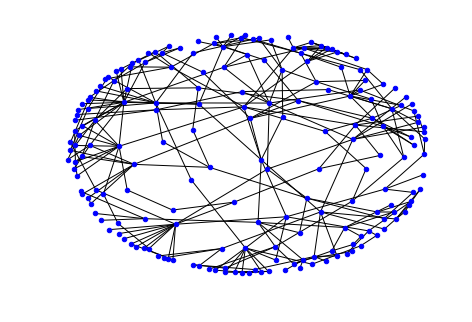

In [28]:
net.draw(g1,node_size=20,node_color="blue",pos=net.spring_layout(g1))

In [15]:
# For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.

degree_centrality = net.degree(g1)
ev_centrality = net.eigenvector_centrality(g1)

In [16]:
# Convert into a pandas dataframe for analysis

rows = []

for item in g1.nodes():
    try:
        rows.append([g1.node[item]['label'],g1.node[item]['post_cnt'],g1.node[item]['like_cnt'],
                           degree_centrality[item],ev_centrality[item]])
    except KeyError:
        pass

df = pd.DataFrame(columns=('name', 'post_cnt', 'like_cnt', 'deg_cent', 'ev_cent'))

for i in range(0,len(rows)):
    df.loc[i] = rows[i] 

In [17]:
df.head()

,name,post_cnt,like_cnt,deg_cent,ev_cent
0,h-o-r-n-g-r-y,137008,0,3.0,0.009726
1,subliminous,1102,3378,3.0,0.003894
2,pocketsquareclothing,3175,69,1.0,0.001322
3,pictoturo,48854,0,2.0,0.001695
4,f525252,9039,3184,11.0,0.067658


In [18]:
df["post_cnt"] = df["post_cnt"].astype("int")
df["like_cnt"] = df["like_cnt"].astype("int")
df.describe()

,post_cnt,like_cnt,deg_cent,ev_cent
count,166.000000,166.00000,166.000000,166.000000
mean,16563.403614,7443.46988,3.216867,0.022149
std,34522.494121,24644.16658,2.481682,0.070855
min,14.000000,-1.00000,1.000000,0.000409
25%,693.000000,15.50000,2.000000,0.001322
50%,2893.000000,471.00000,2.000000,0.002812
75%,13730.250000,3694.50000,4.000000,0.009120
max,244639.000000,215891.00000,14.000000,0.439705


In [19]:
# Remove the nodes with a strangely negative count of likes
df = df[df.like_cnt != -1]
df.shape

(163, 5)

We are left with 163 nodes. Now we'll inspect the pairwise distributions of the variables, discretize the predictor variables post count and like count, and apply t-test to test if they have an effect on degree and eigenvector centrality. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a917050>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11daf3750>]], dtype=object)

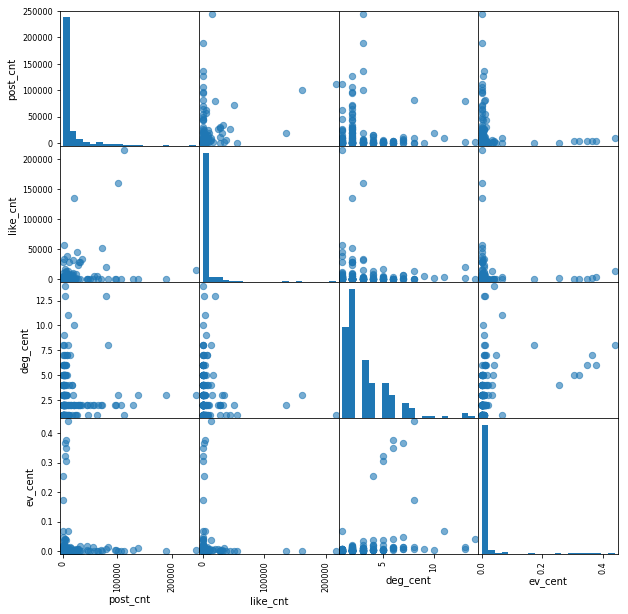

In [20]:
# pairwise plots
pd.scatter_matrix(df, figsize=(10, 10), marker='o',hist_kwds={'bins': 20}, s=40, alpha=.6)

Unexpectedly, there seems to be an inverse relationship between the post and like count and the centrality measures:
there are many users with a lot of posts and likes and low centrality, and a handful of high-centrality users with a low number of posts and likes.
This might be explained by a bias introduced by the data collection process where the blogs closest to the "seed blog" will have a higher probability of a high centrality, and there are only a few of these blogs (first-order neighbors).

In [21]:
# discretize predictors

df["post_cnt_bin"] = pd.qcut(df["post_cnt"], 2) # high/low bin by count of own posts
df["like_cnt_bin"] = pd.qcut(df["like_cnt"], 2) # high/low bin by count of likes

In [22]:
df.head()

,name,post_cnt,like_cnt,deg_cent,ev_cent,post_cnt_bin,like_cnt_bin
0,h-o-r-n-g-r-y,137008,0,3.0,0.009726,"(2991, 244639]","[0, 475]"
1,subliminous,1102,3378,3.0,0.003894,"[14, 2991]","(475, 215891]"
2,pocketsquareclothing,3175,69,1.0,0.001322,"(2991, 244639]","[0, 475]"
3,pictoturo,48854,0,2.0,0.001695,"(2991, 244639]","[0, 475]"
4,f525252,9039,3184,11.0,0.067658,"(2991, 244639]","(475, 215891]"


Before making the t-test, draw boxplots to check our expectations.
The alternative hypothesis was that blogs with high number of posts would have higher centrality.

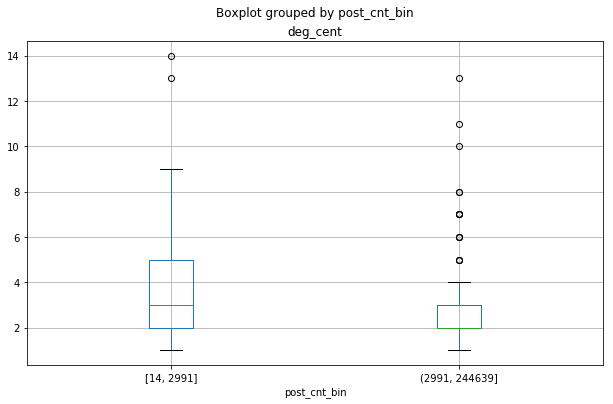

In [29]:
df.boxplot('deg_cent', by='post_cnt_bin', figsize=(10, 6))

We can see that there is no sufficient difference in the medians between the groups, so the *H0* will not be rejected for degree centrality.

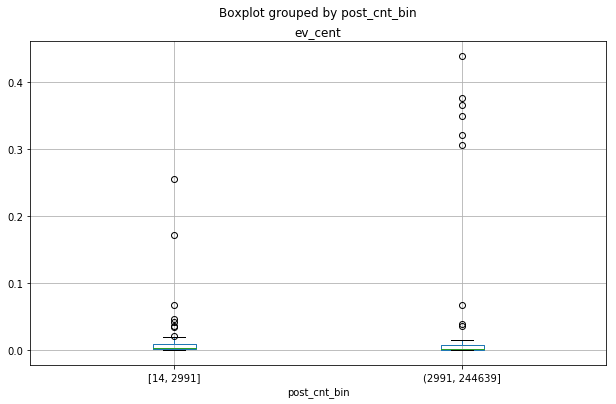

In [30]:
df.boxplot('ev_cent', by='post_cnt_bin', figsize=(10, 6))

We can see that while there are some outliers in the much-posting bin pointing to a higher eigenvector centrality, the overall medians are not sufficiently separated between the two groups. The *H0* will not be rejected for eigenvector centrality. 

**Formally test the hypotheses**

In [25]:
# Set up the testing tool

from scipy.stats import ttest_ind

def print_ttest(group1, group2):
    
    ttest_out = ttest_ind(group1,group2, equal_var = False)
    output = """
                T-Test of difference between two means
                Sample sizes group1: {} | group2: {}
                Test statistic: {}
                p-value: {}
                """.format(group1.size,group2.size,ttest_out[0],ttest_out[1])
    return output

In [32]:
# t-Test for the degree centrality 
deg_group1 = df[df['post_cnt_bin']=='[14, 2991]']['deg_cent']
deg_group2 = df[df['post_cnt_bin']=='(2991, 244639]']['deg_cent']

print print_ttest(deg_group1,deg_group2)


                T-Test of difference between two means
                Sample sizes group1: 82 | group2: 81
                Test statistic: 1.25464769278
                p-value: 0.211425658251
                


We cannot reject the null hypothesis for the degree centrality measure

In [34]:
# t-Test for the eigenvector centrality 
ev_group1 = df[df['post_cnt_bin']=='[14, 2991]']['ev_cent']
ev_group2 = df[df['post_cnt_bin']=='(2991, 244639]']['ev_cent']

print print_ttest(ev_group1,ev_group2)


                T-Test of difference between two means
                Sample sizes group1: 82 | group2: 81
                Test statistic: -1.65286536124
                p-value: 0.101474133038
                


We cannnot reject the null hypothesis at 95% confidence level, but the p-value is close to 0.10 which could be an indicator of the assumption made from the boxplot that given sufficient input data, we could reject the null hypothesis and prove that blogs that make more posts also have a higher eigenvector centrality.

----
  
# Summary and outlook


The analysis has shown that there is not sufficient evidence in the collected data to prove a relationship between the posting activity of a Tumblr blog and its degree and eigenvector centrality. 

Further research can look into the following directions:
  
1) Model the relationships between the blogs in a directed graph and give heigher weight to reciprocral relationships  
2) Combine multiple egonets into a more representative network  
3) Take further blog attributes available via API when modeling the impact on the centrality  


## Reference
  
* Tsvetovat, Kouznetsov (2011). Social Network Analysis for Startups  
* https://github.com/tumblr/pytumblr  
* https://stackoverflow.com/a/3277515/8066374  
* https://networkx.github.io/documentation/networkx-1.10/  
* https://stackoverflow.com/questions/2844516/how-to-filter-a-dictionary-according-to-an-arbitrary-condition-function  
* https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html  
* https://stackoverflow.com/questions/42592493/displaying-pair-plot-in-pandas-data-frame  
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind
